<a href="https://colab.research.google.com/github/Min-ju-Kim/AIFFEL_Going-Deeper/blob/main/4.%20Object%20Detection/%5BGD_8%5DObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Going Deeper 8. Object Detection

### Table of Contents

### 1. Experiment Environment Set-up
* 1.1 Import Libraries

### 2. KITTI Dataset
* 2.1 Load Data
* 2.2 Data Explorations

### 3. Preparing Data
* 3.1 Build a Data Pipeline
* 3.2 Encoding

### 4. Build the Model
* 4.1 Feature Pyramid
* 4.2 Loss

### 5. Model Training

### 6. Check the Results

### 7. Creating an Autonomous Driving System
* 7.1 Autonomous Driving System
* 7.2 System Evaluating

### 8. Retrospection

****

### 1. Experiment Environment Set-up

### 1.1 Import Libraries

In [1]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

DATA_PATH = '/content/sample_data/object_detection/data'

print('🌸~')

🌸~


### 2. KITTI Dataset

* [cvlibs에서 제공하는 KITTI 데이터셋](http://www.cvlibs.net/datasets/kitti/)
* [tensorflow KITTI 데이터셋](https://www.tensorflow.org/datasets/catalog/kitti)

### 2.1 Load Data

In [2]:
# KITTI 데이터셋 다운로드
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('🌸~')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /content/sample_data/object_detection/data/kitti/3.2.0.incomplete5ILKUZ/kitti-train.tfrecord


  0%|          | 0/6347 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /content/sample_data/object_detection/data/kitti/3.2.0.incomplete5ILKUZ/kitti-validation.tfrecord


  0%|          | 0/423 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /content/sample_data/object_detection/data/kitti/3.2.0.incomplete5ILKUZ/kitti-test.tfrecord


  0%|          | 0/711 [00:00<?, ? examples/s]

Dataset kitti downloaded and prepared to /content/sample_data/object_detection/data/kitti/3.2.0. Subsequent calls will reuse this data.
🌸~


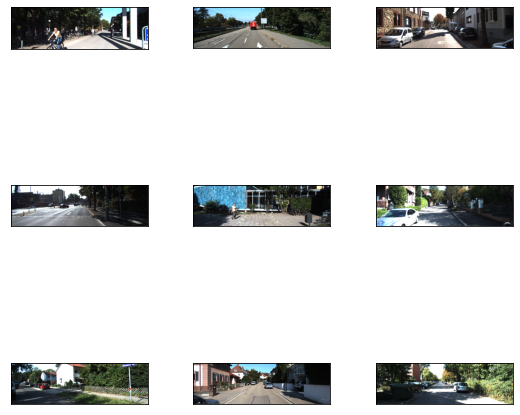

In [3]:
# 다운로드한 데이터셋 확인하기
_ = tfds.show_examples(ds_train, ds_info)

* `ds_info`에서는 불러온 데이터셋의 정보를 확인할 수 있다.
* training data : 6,347개
* test data : 711개
* validation data : 423개
* 라벨 : `alpha`, `bbox`, `dimensions`, `location`, `occluded`, `rotation_y`, `truncated` 등의 정보

In [4]:
# data의 information 확인
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    version=3.2.0,
    description='Kitti contains a suite of vision tasks built using an autonomous driving
platform. The full benchmark contains many tasks such as stereo, optical flow,
visual odometry, etc. This dataset contains the object detection dataset,
including the monocular images and bounding boxes. The dataset contains 7481
training images annotated with 3D bounding boxes. A full description of the
annotations can be found in the readme of the object development kit readme on
the Kitti homepage.',
    homepage='http://www.cvlibs.net/datasets/kitti/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
            'dimensions': Tensor(shape=(3,), dtype=tf.float32),
            'location': Tensor(shape=(3,), dtype

### 2.2 Data Explorations

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-2.96], dtype=float32)>, 'bbox': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.42341334, 0.31099838, 0.5110667 , 0.38967794]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[1.47, 1.74, 4.26]], dtype=float32)>, 'location': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-8.3 ,  2.  , 34.36]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>, 'rotation_y': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([3.09], dtype=float32)>, 'truncated': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, 'type': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>}


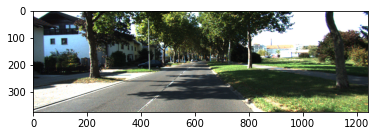

In [5]:
# train에서 하나를 받아 변수 sample에 저장
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())  # Numpy배열을 이미지로 변환
plt.imshow(img)
plt.show()

```python
데이터셋 이해를 위한 예시
Values    Name      Description
----------------------------------------------------------------------------
   1    type         Describes the type of object: 'Car', 'Van', 'Truck',
                     'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram',
                     'Misc' or 'DontCare'
   1    truncated    Float from 0 (non-truncated) to 1 (truncated), where
                     truncated refers to the object leaving image boundaries
   1    occluded     Integer (0,1,2,3) indicating occlusion state:
                     0 = fully visible, 1 = partly occluded
                     2 = largely occluded, 3 = unknown
   1    alpha        Observation angle of object, ranging [-pi..pi]
   4    bbox         2D bounding box of object in the image (0-based index):
                     contains left, top, right, bottom pixel coordinates
   3    dimensions   3D object dimensions: height, width, length (in meters)
   3    location     3D object location x,y,z in camera coordinates (in meters)
   1    rotation_y   Rotation ry around Y-axis in camera coordinates [-pi..pi]
   1    score        Only for results: Float, indicating confidence in
                     detection, needed for p/r curves, higher is better.
```

<p align='middle'><img src='https://i.stack.imgur.com/nBazx.png'></p>

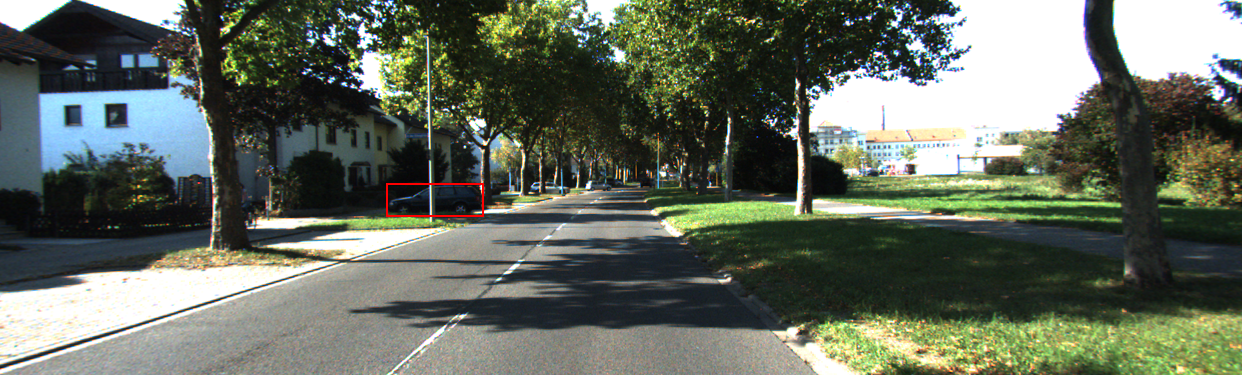

In [6]:
# 이미지의 바운딩 박스(bounding box, bbox) 확인
# 이미지 위에 바운딩 박스를 그려 화면에 표시
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    # bbox = (y_min, x_min, y_max, x_max)
    # object['bbox'] = (left, top, right, bottom pixel coordinates)
    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_max = height - object_bbox[:,0] * height  ###### height에서 빼는 이유?
    y_min = height - object_bbox[:,2] * height  ###### height에서 빼는 이유?

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())

* [Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002)
* 1-stage detector 모델인 YOLO와 SSD는 2-stage detector인 Faster-RCNN 등보다 속도는 빠르지만 성능이 낮은 문제를 가지고 있다. 
* RetinaNet에서는 **focal loss**와 **FPN(Feature Pyramid Network)** 를 적용한 네트워크를 사용한다.

### 3. Preparing Data

### 3.1 Build a Data Pipeline

* 먼저 주어진 KITTI 데이터를 학습에 맞는 형태로 바꿔준다.
* 이때 사용할 데이터 파이프라인을 구축한다.
  1. x와 y좌표 위치 교체
  2. 무작위로 수평 뒤집기(Flip)
  3. 이미지 크기 조정 및 패딩 추가
  4. 좌표계를 [x_min, y_min, x_max, y_max]에서 [x_min, y_min, width, height]으로 수정

<p align='middle'><img src = 'https://www.w3resource.com/w3r_images/numpy-manipulation-stack-function-image-2.png' width='150'></p>

In [7]:
# x와 y좌표 위치 교체
# object['bbox'] = (left, top, right, bottom pixel coordinates)
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

print('🌸~')

🌸~


<p align='middle'><img src='https://media.vlpt.us/images/mjk3136/post/d00f957a-b26e-41cf-9acf-78857240e099/image.png'></p>

In [8]:
# 무작위로 수평 뒤집기(flip)
def random_flip_horizontal(image, boxes):
    # tf.random.uniform() : 0~1까지 랜던한 난수 생성
    if tf.random.uniform(()) > 0.5:  # 50%의 확률로 이미지를 좌우로 뒤집기 적용
        image = tf.image.flip_left_right(image)
        # object['bbox'] = (left, top, right, bottom pixel coordinates)
        # 이미지가 뒤집어질 경우 bbox도 같이 뒤집어져야 한다.
        # x, y좌표의 위치가 변경된 이후 뒤집기 적용 : (1-x1), y1, (1-x2), y2
        boxes = tf.stack( 
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )

    return image, boxes

print('🌸~')

🌸~


* 이미지 크기를 바꿀 때 고려할 점
  * 이미지의 비율 그대로 유지
  * 이미지의 최대/최소 크기 제한
  * 이미지의 크기를 바꾼 후에도 최종적으로 모델에 입력되는 이미지의 크기는 stride의 배수가 될 것

In [9]:
# 이미지 사이즈 변경 및 패딩 추가
def resize_and_pad_image(image, training=True):
    
    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    # 이미지를 `tf.cast`를 통해 float32형태로 바꿔준다.
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    # training 세트이면 
    if training:
        # 640 ~ 1024 사이의 난수를 꺼내 min_side에 저장한다.
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    
    # 비율 = min_side/이미지 shape의 가장 작은 값으로 나눈 값
    ratio = min_side / tf.reduce_min(image_shape)

    # 비율 * 이미지 shape의 가장 큰 값 > 1333.0보다 크면
    if ratio * tf.reduce_max(image_shape) > max_side:
        # 비율 = 1333.0 / 이미지 shape의 가장 큰 값
        ratio = max_side / tf.reduce_max(image_shape)
    
    # 이미지 shape = 비율 * 이미지 shape
    image_shape = ratio * image_shape
    # 이미지 사이즈를 변경한다.
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    # 이미지의 크기를 바꾼 후에도 최종적으로 모델에 입력되는 이미지의 크기는 stride의 배수가 될 것
    # 패딩 진행
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

print('🌸~')

🌸~


* 참고자료
```python
def box_corner_to_center(boxes):
    """Convert from (upper_left, bottom_right) to (center, width, height)""" 
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3] 
    cx = (x1 + x2) / 2 
    cy = (y1 + y2) / 2 
    w = x2 - x1 
    h = y2 - y1 
    boxes = torch.stack((cx, cy, w, h), axis=-1) 
    return boxes
```

In [10]:
# 좌표들을 width, height로 변경
# bbox의 중심 x, y 좌표 및 width, height가 반환된다.
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

print('🌸~')

🌸~


In [11]:
# 위에서 만든 함수들 연결
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

print('🌸~')

🌸~


### 3.2 Encoding

In [12]:
# AnchorBox 생성
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

print('🌸~')

🌸~


In [13]:
# IoU 계산
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

print('🌸~')

🌸~


In [14]:
# 실제 라벨을 Anchor Box에 맞춰주는 클래스
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()
    
print('🌸~')

🌸~


### 4. Build the Model

### 4.1 Feature Pyramid

<p align='middle'><img src = 'https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fwsui0%2FbtqUuL9T7LI%2F18lKd5H2I0JKMyKY1Q180k%2Fimg.png' width='300'></p>

<p align='middle'><img src = 'https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fk9LUD%2FbtqUtXbErVx%2F1mZ793U5mBK5KgJPqsR9qK%2Fimg.png' width='600'></p>

<p align='middle'><img src = 'https://d3s0tskafalll9.cloudfront.net/media/original_images/gc-4v2-p-5-1.png' width='450'></p>

In [15]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

print('🌸~')

🌸~


<p align='middle'><img src = 'https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FqjSwj%2FbtqWTYe0Nzt%2FjYBgbiNmSdaBIYiVTY8yMk%2Fimg.png' width='600'></p>

In [16]:
# class를 예측하는 head와 box를 예측하는 head
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

print('🌸~')

🌸~


In [17]:
# RetinaNet의 backbone : ResNet50
# FPN에 이용할 수 있도록 중간 레이어도 output으로 연결
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

print('🌸~')

🌸~


In [18]:
# RetinaNet
# Backbone + FPN + classification용 head + box용 head 
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

print('🌸~')

🌸~


### 4.2 Loss

In [19]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

print('🌸~')

🌸~


### 5. Model Training

In [20]:
# 만들어 놓은 클래스와 함수를 이용해서 모델을 조립
num_classes = 8
batch_size = 8

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

print('🌸~')

94781440/94765736 [==============================] - 1s 0us/step
🌸~


In [21]:
# 논문에서는 8개의 GPU를 사용했기 때문에 우리 환경과는 맞지 않는다.
# 그래서 Learning Rate를 적절히 바꿔준다.
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

In [22]:
# 데이터 전처리를 위한 파이프라인도 만들기
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

print('🌸~')

🌸~


In [23]:
# 모델 학습
model_dir = '/content/sample_data/object_detection/data/checkpoints'
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

epochs = 20

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks_list
)

Epoch 1/20
793/793 [==============================] - ETA: 0s - loss: 2.8064
Epoch 1: saving model to /content/sample_data/object_detection/data/checkpoints/weights_epoch_1
793/793 [==============================] - 761s 931ms/step - loss: 2.8064 - val_loss: 1.8638
Epoch 2/20
793/793 [==============================] - ETA: 0s - loss: 1.2062
Epoch 2: saving model to /content/sample_data/object_detection/data/checkpoints/weights_epoch_2
793/793 [==============================] - 739s 930ms/step - loss: 1.2062 - val_loss: 1.4055
Epoch 3/20
793/793 [==============================] - ETA: 0s - loss: 0.8447
Epoch 3: saving model to /content/sample_data/object_detection/data/checkpoints/weights_epoch_3
793/793 [==============================] - 740s 930ms/step - loss: 0.8447 - val_loss: 1.2955
Epoch 4/20
793/793 [==============================] - ETA: 0s - loss: 0.6745
Epoch 4: saving model to /content/sample_data/object_detection/data/checkpoints/weights_epoch_4
793/793 [====================

### 6. Check the Results

In [24]:
# 학습된 모델 불러오기
model_dir = '/content/sample_data/object_detection/data/checkpoints'
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)

print('🌸~')

🌸~


In [25]:
# 모델의 추론 결과를 처리할 함수를 레이어 형식으로 만든다.
# 100개의 후보만 골라 처리
# `tf.image.combined_non_max_suppression` 사용
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

print('🌸~')

🌸~


In [26]:
# 추론이 가능한 모델을 조립
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

print('🌸~')

🌸~


In [27]:
# 모델의 추론 결과 시각화 함수
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        y1 = image.shape[0] - y2
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            x1,
            y1,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

print('🌸~')

🌸~


In [28]:
# 추론 시 입력데이터를 전처리하기 위한 함수
# 학습을 위한 전처리와 추론을 위한 전처리가 다르기 때문에 따로 작성된다.
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

print('🌸~')

🌸~


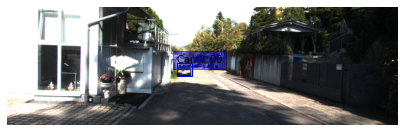

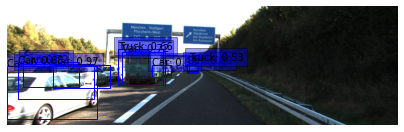

In [29]:
# 학습된 결과를 확인한다.
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(2):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

### 7. Creating an Autonomous Driving System

* 입력으로 이미지 경로를 받는다.
* 정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환한다.
* 조건은 다음과 같다.
  * 사람이 한 명 이상 있는 경우
  * 차량의 크기(width or height)가 300px이상인 경우

### 7.1 Autonomous Driving System

In [34]:
def self_drive_assist(img_path, size_limit=300, visualize=True):
    image = Image.open(img_path)
    image = np.array(image)
    image = tf.cast(image, dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    boxes = detections.nmsed_boxes[0][:num_detections] / ratio
    classes = class_names
    scores = detections.nmsed_scores[0][:num_detections]

    # display images
    if visualize:
        result = 'Go'
        for box, score, _cls in zip(boxes, scores, classes):

            x1, y1, x2, y2 = box
            w, h = x2 - x1, y2 - y1
            y1 = image.shape[0] - y2
            
            if w >= size_limit or h >= size_limit or _cls == 'Pedestrian':
                result = 'Stop'
            else:
                result = 'Go'

        image = np.array(image, dtype=np.uint8)
        plt.axis("off")
        plt.imshow(image)

        text = "{}: {:.2f}".format(_cls, score)
        ax = plt.gca()
        color = [0, 0, 1]
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=1
        )
        ax.add_patch(patch)
        ax.text(
            x1,
            y1,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
        plt.show()


    return result

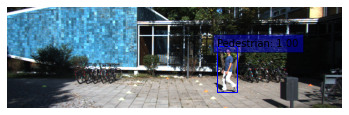

Stop


In [35]:
img_path = '/content/sample_data/object_detection/data/stop_1.png'
print(self_drive_assist(img_path))

### 7.2 System Evaluating

In [36]:
import os

def test_system(func):
    work_dir = '/content/sample_data/object_detection/data'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = self_drive_assist(image_path)
        print(image_file)
        print(f'prediction: {pred}, answer: {answer}\n')
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

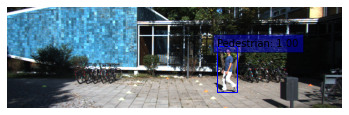

stop_1.png
prediction: Stop, answer: Stop



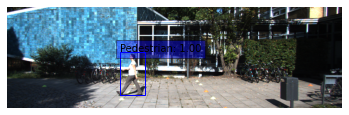

stop_2.png
prediction: Stop, answer: Stop



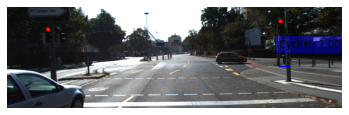

stop_3.png
prediction: Go, answer: Stop



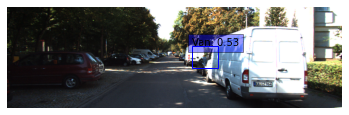

stop_4.png
prediction: Go, answer: Stop



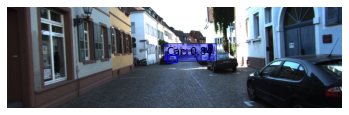

stop_5.png
prediction: Go, answer: Stop



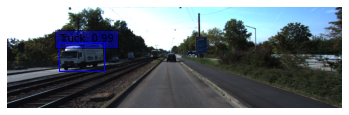

go_1.png
prediction: Go, answer: Go



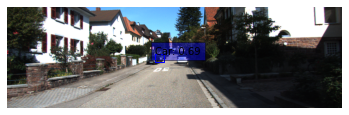

go_2.png
prediction: Go, answer: Go



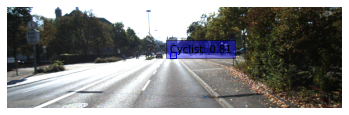

go_3.png
prediction: Go, answer: Go



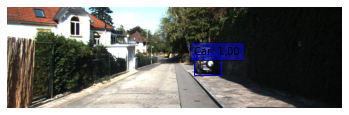

go_4.png
prediction: Go, answer: Go



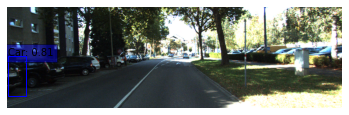

go_5.png
prediction: Go, answer: Go

70점입니다.


In [37]:
test_system(self_drive_assist)

* 테스트 이미지에서 물체를 제대로 인식하지 못하는 경우들이 발생하고 있다.
* 예상되는 원인들 중 가장 가능성이 있어보이는 이유는 학습이 제대로 이루어지지 못한 경우이다.


### 8. Retrospection

### 8.1 What was difficult

* 정의된 class와 함수가 너무 많아 코드를 이해하기 힘들었다.
* 코드상 box를 그리는 부분에서 틀린 부분이 있어 원인을 찾는게 힘들었다.
* 1 epoch 당 학습하는 시간이 너무 길다😥

### 8.2 What I found out

1. `PIL.Image.fromarray(obj, mode=None)`
*  배열 객체를 입력으로 받아 배열 객체에서 만든 이미지 객체를 반환
* `obj` : Object with array interface
* `mode` : Optional mode to use when reading `obj`. Will be determined from type if `None`.

2. `numpy.stack(arrays, axis=0, out=None)`
* 새 축을 따라 배열 시퀀스를 결합
<p align='middle'><img src = 'https://miro.medium.com/max/1050/1*lFZzE9PgKTRR8jlFI4EUtw.png' height='300'></p>

3. `tf.stack(values, axis=0, name='stack')`
* `values` : A list of Tensor objects with the same shape and type.
* `output` : A stacked Tensor with the same type as values.
* This is the opposite of unstack. 
* The numpy equivalent is `np.stack`
```python
>>> np.array_equal(np.stack([x, y, z]), tf.stack([x, y, z]))
True
```

4. `tf.math.reduce_min(input_tensor, axis=None, keepdims=False, name=None)`
* 텐서 차원에 걸쳐 요소의 `tf.math.minimum`을 계산한다.

5. `tf.math.reduce_max(input_tensor, axis=None, keepdims=False, name=None)`
* 텐서 차원에 걸쳐 요소의 `tf.math.maximum`을 계산한다.
* `axis` : 줄일 차원이다. 만약 None (the default)이면, 모든 차원을 줄인다. 범위는 무조건 `[-rank(input_tensor),rank(input_tensor))`이여야 한다.

6. `tf.math.ceil(x, name=None)`
* 입력의 상한선을 요소별로 반환
* -값은 버림, +값은 올림처리

### 8.3 What I want to know more about

* RetinaNet을 완전히 이해한 것은 아니여서 더 공부를 해야할 것 같다.

### 8.4 Self-Resolution

* 자율주행시스템 평가하는 부분 코드를 짤 때 시간도 많이 걸렸고, 생각대로 코딩이 잘 되지않아 답답했다.